In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load product coordinates
product_data = pd.read_csv("/home/hp/results/MOUSE/level1/F139L/replica000/product.csv")

# Print the first few rows to understand the structure
print("DataFrame shape:", product_data.shape)
print("DataFrame columns:", product_data.columns.tolist())
print("First few rows:")
print(product_data.head())

# Define charges for the product state (ensure this matches your atom count)
charges_product = {
    1: -0.9, 2: 0.418, 3: -0.3, 4: 0.1, 5: 0.1, 6: 0.14, 7: 0.06, 8: -0.5, 9: 0.3,
    10: -0.418, 11: -0.418, 12: 0.418, 13: 0.418, 14: -0.4965, 15: 0.48, 16: 0.48, 17: 0.2858,
    18: -0.503, 19: -0.12, 20: 0.06, 21: 0.06, 22: 0.2157, 23: 0.06, 24: 0.06
}

# STEP 1: First determine the correct format of your coordinates
# Assuming the second, third, and fourth columns contain x, y, z coordinates
try:
    if 'x' in product_data.columns and 'y' in product_data.columns and 'z' in product_data.columns:
        x_col, y_col, z_col = 'x', 'y', 'z'
    else:
        numerical_cols = product_data.select_dtypes(include=[np.number]).columns
        if len(numerical_cols) >= 3:
            x_col, y_col, z_col = numerical_cols[:3]
        else:
            x_col, y_col, z_col = product_data.columns[1], product_data.columns[2], product_data.columns[3]
    
    print(f"Using columns: {x_col}, {y_col}, {z_col} for coordinates")
    
    # Extract coordinates properly
    coordinates = np.array([
        product_data[x_col].values,
        product_data[y_col].values,
        product_data[z_col].values
    ]).T  # Transpose to get (n_atoms, 3) shape
    
    print("Coordinates shape:", coordinates.shape)
    print("First few coordinates:")
    print(coordinates[:5])

except Exception as e:
    print(f"Error extracting coordinates: {e}")
    print("Trying alternative approach...")
    
    numerical_data = product_data.select_dtypes(include=[np.number]).values
    if numerical_data.shape[1] % 3 == 0:
        n_atoms = numerical_data.shape[1] // 3
        coordinates = numerical_data.reshape(-1, 3)
        print(f"Reshaped to {coordinates.shape}")
    else:
        coordinates = product_data.iloc[:, 1:4].values
        print(f"Using first 3 data columns, shape: {coordinates.shape}")

# Ensure that the number of coordinates matches the number of charges
num_atoms = len(coordinates)
num_charges = len(charges_product)

print(f"Number of atoms: {num_atoms}, Number of charges: {num_charges}")

if num_atoms > num_charges:
    print(f"Warning: More atoms ({num_atoms}) than charges ({num_charges}). Using only the first {num_charges} atoms.")
    coordinates = coordinates[:num_charges]
elif num_atoms < num_charges:
    print(f"Warning: Fewer atoms ({num_atoms}) than charges ({num_charges}). Using only the first {num_atoms} charges.")
    charges_subset = {i+1: charges_product[i+1] for i in range(num_atoms)}
    charges_product = charges_subset

# Calculate center of mass
center_of_mass = np.mean(coordinates, axis=0)
print("Center of Mass:", center_of_mass)

# Calculate dipole moment relative to center of mass
dipole_moment = np.zeros(3)
for i in range(len(coordinates)):
    r_i = coordinates[i] - center_of_mass
    dipole_moment += charges_product[i+1] * r_i

# Calculate dipole moment magnitude
dipole_magnitude = np.linalg.norm(dipole_moment)
print("Dipole Moment Vector:", dipole_moment)
print("Dipole Moment Magnitude:", dipole_magnitude)

# Atom names for product state (example, adjust as needed)
atom_names_product = [
    "SG", "HG1", "CB", "HB1", "HB2", "CA", "HA", "N", "HN", 
    "O1", "O2", "H1", "H2", "NE2", "HE21", "HE22", "CD", "OE1", 
    "CB", "HB1", "HB2", "CG", "HG1", "HG2"
]

# Create a 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot atoms
ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2], color='blue', s=50, label='Atoms')

# Set axis limits
x_min, x_max = min(coordinates[:, 0]), max(coordinates[:, 0])
y_min, y_max = min(coordinates[:, 1]), max(coordinates[:, 1])
z_min, z_max = min(coordinates[:, 2]), max(coordinates[:, 2])

# Add some padding
padding = 5
ax.set_xlim(x_min - padding, x_max + padding)
ax.set_ylim(y_min - padding, y_max + padding)
ax.set_zlim(z_min - padding, z_max + padding)

# Add atom names as labels
for i in range(len(coordinates)):
    ax.text(coordinates[i, 0], coordinates[i, 1], coordinates[i, 2], f"{atom_names_product[i]} ({i+1})", fontsize=8)

# Plot center of mass
ax.scatter([center_of_mass[0]], [center_of_mass[1]], [center_of_mass[2]], 
           color='green', s=100, marker='o', label='Center of Mass')

# Make dipole moment vector visible
scale_factor = max(10.0, 10.0 / max(dipole_magnitude, 0.001))
ax.quiver(center_of_mass[0], center_of_mass[1], center_of_mass[2], 
         dipole_moment[0], dipole_moment[1], dipole_moment[2], 
         color='red', linewidth=3, length=scale_factor, normalize=True,
         arrow_length_ratio=0.2, label='Dipole Moment')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Plot of Product Atoms and Dipole Moment')

# Add text with dipole moment value
text_pos = [center_of_mass[0], center_of_mass[1], z_max]
ax.text(text_pos[0], text_pos[1], text_pos[2], 
        f'Dipole: {dipole_magnitude:.3f}', 
        fontsize=12, color='red')

# Add a legend
ax.legend()

# Add grid for better visualization
ax.grid(True)

# Show the plot
plt.tight_layout()
#plt.savefig('product_dipole_plot.png', dpi=300, bbox_inches='tight')
plt.show()


Processing replica000...
Reactant dipole for replica000: 3.3270
Product dipole for replica000: 13.0470
Processing replica001...
Reactant dipole for replica001: 3.3270
Product dipole for replica001: 13.0470
Processing replica002...
Reactant dipole for replica002: 3.3270
Product dipole for replica002: 13.0470
Processing replica003...
Reactant dipole for replica003: 3.3270
Product dipole for replica003: 13.0470
Processing replica004...
Reactant dipole for replica004: 3.3270
Product dipole for replica004: 13.0470
Processing replica005...
Reactant dipole for replica005: 3.3270
Product dipole for replica005: 13.0470
Processing replica006...
Reactant dipole for replica006: 3.3270
Product dipole for replica006: 13.0470
Processing replica007...
Reactant dipole for replica007: 3.3270
Product dipole for replica007: 13.0470
Processing replica008...
Reactant dipole for replica008: 3.3270
Product dipole for replica008: 13.0470
Processing replica009...
Reactant dipole for replica009: 3.3270
Product d

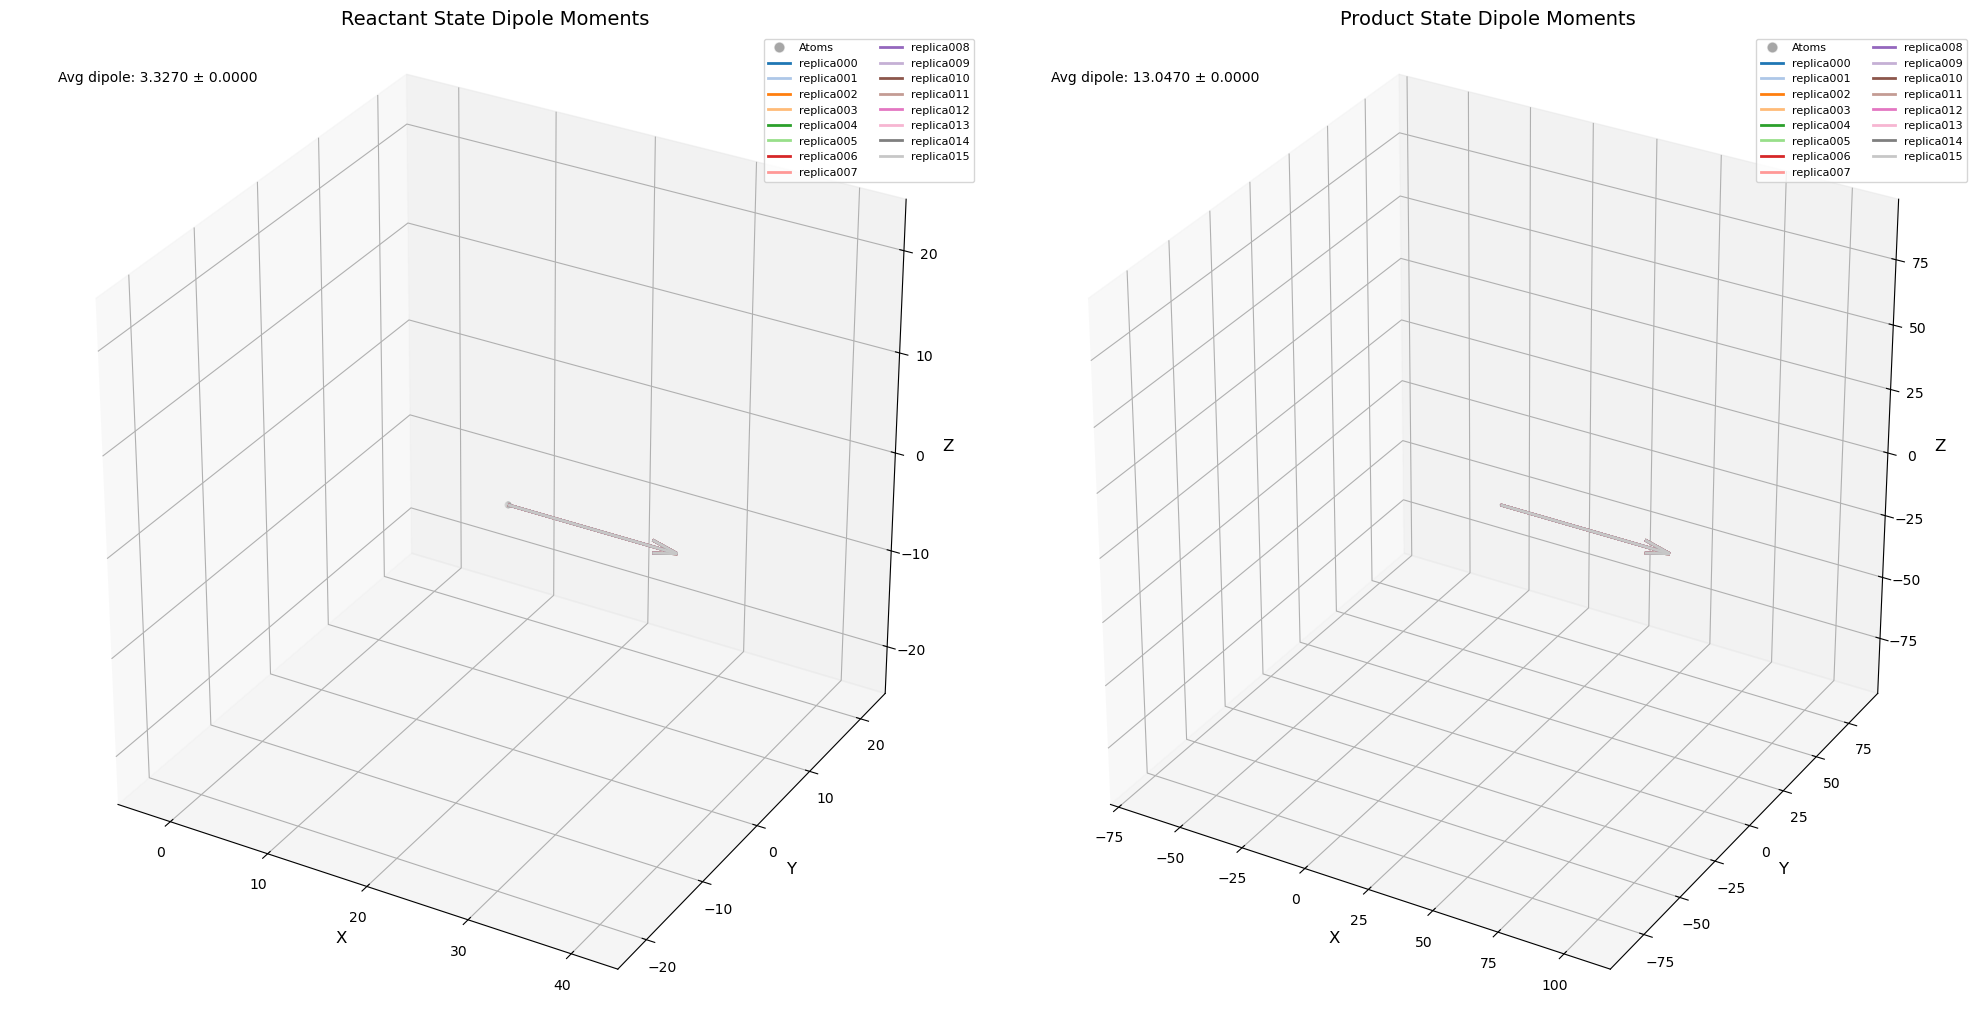

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

# Define the base directory for the replicas
base_dir = "/home/hp/results/MOUSE/level3/F139L"

# Define charges for the reactant state
charges_reactant = {
    1: -0.335, 2: 0.155, 3: 0.06, 4: 0.06, 5: 0.06, 6: 0.14, 7: 0.06, 8: -0.5, 9: 0.3,
    10: -0.418, 11: -0.418, 12: 0.418, 13: 0.418, 14: -0.76, 15: 0.38, 16: 0.38, 17: 0.5,
    18: -0.5, 19: -0.12, 20: 0.06, 21: 0.06, 22: -0.12, 23: 0.06, 24: 0.06
}

# Define charges for the product state
charges_product = {
    1: -0.9, 2: 0.418, 3: -0.3, 4: 0.1, 5: 0.1, 6: 0.14, 7: 0.06, 8: -0.5, 9: 0.3,
    10: -0.418, 11: -0.418, 12: 0.418, 13: 0.418, 14: -0.4965, 15: 0.48, 16: 0.48, 17: 0.2858,
    18: -0.503, 19: -0.12, 20: 0.06, 21: 0.06, 22: 0.2157, 23: 0.06, 24: 0.06
}

# Get list of replica directories (from replica000 to replica015)
replica_dirs = [f"replica{str(i).zfill(3)}" for i in range(16)]

# Create a figure with 2 subplots side by side
fig = plt.figure(figsize=(20, 10))

# Create the reactant subplot
ax1 = fig.add_subplot(121, projection='3d')
# Create the product subplot
ax2 = fig.add_subplot(122, projection='3d')

# Store reactant and product data
reactant_dipoles = []
reactant_centers = []
reactant_coordinates = []
product_dipoles = []
product_centers = []
product_coordinates = []
valid_replicas = []

# Create distinct colors for replicas
colors = plt.cm.tab20(np.linspace(0, 1, 20))
colors = np.vstack((colors, plt.cm.Set1(np.linspace(0, 1, 9))))
colors = colors[:len(replica_dirs)]

# Process all replicas
for i, replica in enumerate(replica_dirs):
    print(f"Processing {replica}...")
    
    # Process reactant data
    reactant_file = os.path.join(base_dir, replica, "reactant.csv")
    product_file = os.path.join(base_dir, replica, "product.csv")
    
    # Skip if files don't exist
    if not os.path.exists(reactant_file) or not os.path.exists(product_file):
        print(f"Warning: Files missing for {replica}. Skipping...")
        continue
    
    # Load data
    try:
        reactant_data = pd.read_csv(reactant_file)
        product_data = pd.read_csv(product_file)
    except Exception as e:
        print(f"Error reading files for {replica}: {e}")
        continue
    
    # Process reactant coordinates
    try:
        # Determine column names for coordinates
        if 'x' in reactant_data.columns and 'y' in reactant_data.columns and 'z' in reactant_data.columns:
            x_col, y_col, z_col = 'x', 'y', 'z'
        else:
            numerical_cols = reactant_data.select_dtypes(include=[np.number]).columns
            if len(numerical_cols) >= 3:
                x_col, y_col, z_col = numerical_cols[:3]
            else:
                x_col, y_col, z_col = reactant_data.columns[1], reactant_data.columns[2], reactant_data.columns[3]
        
        # Extract reactant coordinates
        reactant_coord = np.array([
            reactant_data[x_col].values,
            reactant_data[y_col].values,
            reactant_data[z_col].values
        ]).T
        
        reactant_coordinates.append(reactant_coord)
        
        # Process product coordinates (use the same column names)
        product_coord = np.array([
            product_data[x_col].values,
            product_data[y_col].values,
            product_data[z_col].values
        ]).T
        
        product_coordinates.append(product_coord)
        valid_replicas.append(replica)
        
    except Exception as e:
        print(f"Error extracting coordinates for {replica}: {e}")
        continue
    
    # Match coordinates to charges for reactant
    num_atoms_reactant = len(reactant_coord)
    charges_used_reactant = {}
    for j in range(min(num_atoms_reactant, len(charges_reactant))):
        charges_used_reactant[j+1] = charges_reactant[j+1]
    
    # Match coordinates to charges for product
    num_atoms_product = len(product_coord)
    charges_used_product = {}
    for j in range(min(num_atoms_product, len(charges_product))):
        charges_used_product[j+1] = charges_product[j+1]
    
    # Check for NaN values
    if np.any(np.isnan(reactant_coord)) or np.any(np.isnan(product_coord)):
        print(f"Warning: NaN values detected for {replica}. Cleaning up...")
        reactant_coord = np.nan_to_num(reactant_coord, nan=0.0)
        product_coord = np.nan_to_num(product_coord, nan=0.0)
    
    # Calculate center of mass for reactant
    reactant_com = np.mean(reactant_coord, axis=0)
    reactant_centers.append(reactant_com)
    
    # Calculate center of mass for product
    product_com = np.mean(product_coord, axis=0)
    product_centers.append(product_com)
    
    # Calculate dipole moment for reactant
    reactant_dipole = np.zeros(3)
    for j in range(len(charges_used_reactant)):
        if j < len(reactant_coord):
            r_i = reactant_coord[j] - reactant_com
            reactant_dipole += charges_used_reactant[j+1] * r_i
    
    reactant_dipoles.append(reactant_dipole)
    
    # Calculate dipole moment for product
    product_dipole = np.zeros(3)
    for j in range(len(charges_used_product)):
        if j < len(product_coord):
            r_i = product_coord[j] - product_com
            product_dipole += charges_used_product[j+1] * r_i
    
    product_dipoles.append(product_dipole)
    
    # Print dipole magnitudes
    reactant_magnitude = np.linalg.norm(reactant_dipole)
    product_magnitude = np.linalg.norm(product_dipole)
    print(f"Reactant dipole for {replica}: {reactant_magnitude:.4f}")
    print(f"Product dipole for {replica}: {product_magnitude:.4f}")

# Calculate common reference points
if reactant_centers and product_centers:
    reactant_origin = np.mean(reactant_centers, axis=0)
    product_origin = np.mean(product_centers, axis=0)
else:
    reactant_origin = np.array([0, 0, 0])
    product_origin = np.array([0, 0, 0])

# Find maximum dipole magnitudes for scaling
reactant_magnitudes = [np.linalg.norm(d) for d in reactant_dipoles]
product_magnitudes = [np.linalg.norm(d) for d in product_dipoles]

max_reactant_magnitude = max(reactant_magnitudes) if reactant_magnitudes else 1.0
max_product_magnitude = max(product_magnitudes) if product_magnitudes else 1.0

# Plot atoms from first replica if available
if reactant_coordinates:
    # First replica atoms
    ax1.scatter(reactant_coordinates[0][:, 0], reactant_coordinates[0][:, 1], 
               reactant_coordinates[0][:, 2], color='gray', s=30, alpha=0.3)

if product_coordinates:
    # First replica atoms
    ax2.scatter(product_coordinates[0][:, 0], product_coordinates[0][:, 1], 
               product_coordinates[0][:, 2], color='gray', s=30, alpha=0.3)

# Create legend elements
legend_elements_reactant = [plt.Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor='gray', markersize=8, 
                             label='Atoms', alpha=0.7)]

legend_elements_product = [plt.Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor='gray', markersize=8, 
                             label='Atoms', alpha=0.7)]

# Scale factor for arrow lengths
scale_factor = 5.0

# Plot reactant dipoles
for i, (replica, dipole) in enumerate(zip(valid_replicas, reactant_dipoles)):
    # Skip tiny dipoles
    dipole_magnitude = np.linalg.norm(dipole)
    if dipole_magnitude < 1e-10:
        continue
    
    # Use color based on replica index
    color = colors[i % len(colors)]
    
    # Plot dipole
    ax1.quiver(reactant_origin[0], reactant_origin[1], reactant_origin[2],
             dipole[0], dipole[1], dipole[2],
             color=color, linewidth=2,
             length=scale_factor * (dipole_magnitude / max_reactant_magnitude),
             arrow_length_ratio=0.15)
    
    # Add to legend
    legend_elements_reactant.append(plt.Line2D([0], [0], color=color, lw=2, label=f'{replica}'))

# Plot product dipoles
for i, (replica, dipole) in enumerate(zip(valid_replicas, product_dipoles)):
    # Skip tiny dipoles
    dipole_magnitude = np.linalg.norm(dipole)
    if dipole_magnitude < 1e-10:
        continue
    
    # Use color based on replica index (same color for same replica)
    color = colors[i % len(colors)]
    
    # Plot dipole
    ax2.quiver(product_origin[0], product_origin[1], product_origin[2],
             dipole[0], dipole[1], dipole[2],
             color=color, linewidth=2,
             length=scale_factor * (dipole_magnitude / max_product_magnitude),
             arrow_length_ratio=0.15)
    
    # Add to legend
    legend_elements_product.append(plt.Line2D([0], [0], color=color, lw=2, label=f'{replica}'))

# Create small spheres at origins
for ax, origin in [(ax1, reactant_origin), (ax2, product_origin)]:
    u = np.linspace(0, 2 * np.pi, 20)
    v = np.linspace(0, np.pi, 20)
    x = 0.3 * np.outer(np.cos(u), np.sin(v)) + origin[0]
    y = 0.3 * np.outer(np.sin(u), np.sin(v)) + origin[1]
    z = 0.3 * np.outer(np.ones(np.size(u)), np.cos(v)) + origin[2]
    ax.plot_surface(x, y, z, color='lightgray', alpha=0.3)

# Set axis limits
def set_axis_limits(ax, dipoles, origin, scale_factor):
    if dipoles:
        max_coord = np.max(np.abs(dipoles)) * scale_factor * 1.5
        ax.set_xlim(origin[0] - max_coord, origin[0] + max_coord)
        ax.set_ylim(origin[1] - max_coord, origin[1] + max_coord)
        ax.set_zlim(origin[2] - max_coord, origin[2] + max_coord)
    else:
        ax.set_xlim(-5, 5)
        ax.set_ylim(-5, 5)
        ax.set_zlim(-5, 5)

set_axis_limits(ax1, reactant_dipoles, reactant_origin, scale_factor)
set_axis_limits(ax2, product_dipoles, product_origin, scale_factor)

# Set aspect ratios
ax1.set_box_aspect([1, 1, 1])
ax2.set_box_aspect([1, 1, 1])

# Set labels and titles
ax1.set_xlabel('X', fontsize=12)
ax1.set_ylabel('Y', fontsize=12)
ax1.set_zlabel('Z', fontsize=12)
ax1.set_title('Reactant State Dipole Moments', fontsize=14)

ax2.set_xlabel('X', fontsize=12)
ax2.set_ylabel('Y', fontsize=12)
ax2.set_zlabel('Z', fontsize=12)
ax2.set_title('Product State Dipole Moments', fontsize=14)

# Add grids
ax1.grid(True, alpha=0.3)
ax2.grid(True, alpha=0.3)

# Create the legends
ncol = 2 if len(valid_replicas) > 8 else 1
ax1.legend(handles=legend_elements_reactant, loc='upper right', fontsize=8, ncol=ncol)
ax2.legend(handles=legend_elements_product, loc='upper right', fontsize=8, ncol=ncol)

# Add statistical information
if reactant_magnitudes:
    avg_reactant = np.mean(reactant_magnitudes)
    std_reactant = np.std(reactant_magnitudes)
    reactant_info = f"Avg dipole: {avg_reactant:.4f} ± {std_reactant:.4f}"
    ax1.text2D(0.05, 0.95, reactant_info, transform=ax1.transAxes, fontsize=10)

if product_magnitudes:
    avg_product = np.mean(product_magnitudes)
    std_product = np.std(product_magnitudes)
    product_info = f"Avg dipole: {avg_product:.4f} ± {std_product:.4f}"
    ax2.text2D(0.05, 0.95, product_info, transform=ax2.transAxes, fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()